## Simple Workflow for Protein Atlass Image Classificacation Kaggle Competition  

I'd like to share my baseline for this competition. It's based on amazing fastai courses and library 
https://github.com/fastai/fastai

My way was to simply combine 3 1-channel images (discarding yellow images) to 1 RGB 3-channel image with greate tool imagemagick https://www.imagemagick.org/script/index.php

Combining images would be as simple as this command in linux shell:

`convert r.jpg g.jpg b.jpg -channel RGB -combine combined.jpg`

So workflow would assume you have a combined images in your train and test folders.

This code would not get you on top of LB, but provide a nice and simple way to start playing with data and experimenting further.

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../tests/')
from challenge_setup import *
model_name ='fastai_starter_focalLoss'

In [4]:
# path = Config.data_path()/'atlas'
# path.mkdir(exist_ok=True)
# path

In [5]:
path.ls()

[PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/sample_test'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/test_combined'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/sample_submission.csv'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/copy_samples.sh'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/sample_submission_small.csv'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/train_small.csv'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/train_combined'),
 PosixPath('/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/input/models'),
 PosixPath('/home/fabsta/projects/datascience/competit

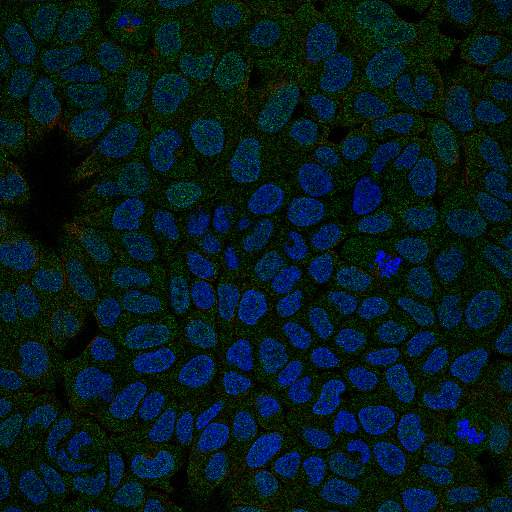

In [6]:
open_image(path/'train_combined/79a6b502-bbb4-11e8-b2ba-ac1f6b6435d0.png')

### Labels 

0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings  

### Data Preparation

In [7]:
np.random.seed(42)

In [8]:
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [9]:
bs = 64

In [10]:
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train.csv', sep=' ', folder='train_combined', suffix='.png')  
       .random_split_by_pct(0.2))

## 64

In [11]:
# start with smaller size
data = (src.datasets()
        .transform(tfms, size=64)
        .databunch(bs=bs).normalize(imagenet_stats))

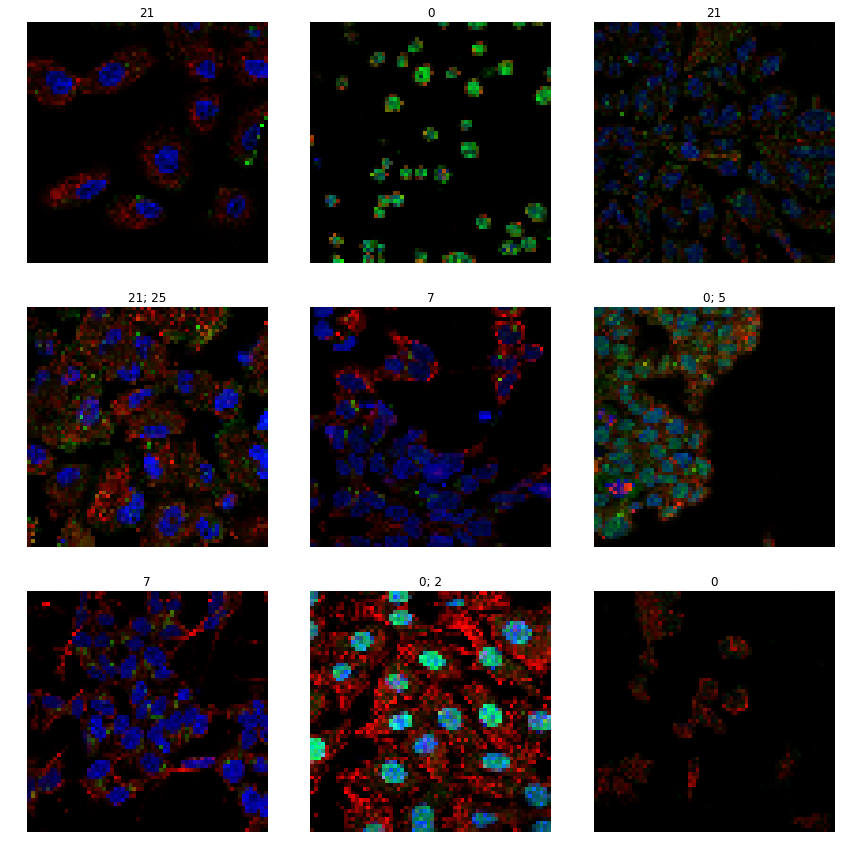

In [12]:
data.show_batch(rows=3, figsize=(12,12))

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
    
def f1(y_pred, y_true, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True):
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=0)
    prec = TP/(y_pred.sum(dim=0)+eps)
    rec = TP/(y_true.sum(dim=0)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(0)
    prec = TP/(y_pred.sum(0)+1e-7)
    rec = TP/(y_true.sum(0)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

### Training

In [14]:
# use pretrained model
arch = models.resnet34

In [15]:
f1_score = partial(fbeta, thresh=0.2, beta=1.)
#learn = create_cnn(data, arch, metrics=f1_score)
learn = create_cnn(data, arch,  metrics=[accuracy_thresh, f1 , f1_score])


In [16]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


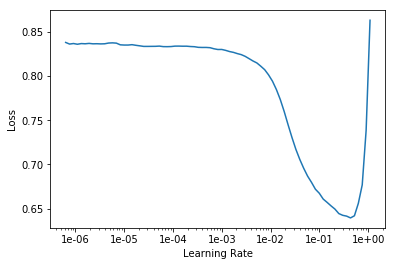

In [17]:
learn.recorder.plot()

In [18]:
lr = 3e-2

In [19]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:47
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.163788    0.158066    0.947883         0.061625  0.375633  (00:57)
2      0.167074    0.162598    0.947647         0.057739  0.378608  (00:57)
3      0.162135    0.167425    0.947722         0.047135  0.406984  (00:57)
4      0.153877    0.153205    0.949061         0.065010  0.411939  (00:57)
5      0.150491    0.148963    0.949917         0.063837  0.424468  (00:57)



My validation Fbeta does not match really good with LB, it's allways ~40-45% better. But goes up and down as LB score does.

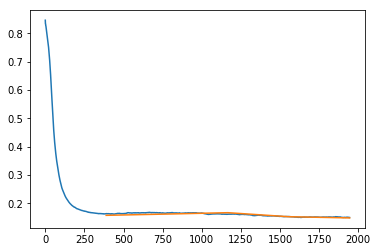

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.save(model_name+'_stage-1-64-rn34')

#### Unfreeze to train pretrained weights a bit

In [22]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


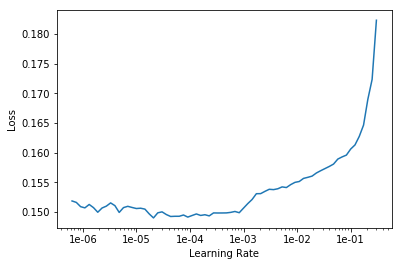

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 04:49
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.150233    0.148805    0.949785         0.064668  0.423330  (00:57)
2      0.150867    0.147510    0.949952         0.066638  0.426320  (00:57)
3      0.149256    0.151932    0.949825         0.068406  0.428228  (00:58)
4      0.148242    0.149746    0.950072         0.068857  0.427738  (00:57)
5      0.148208    0.146742    0.950159         0.068609  0.426892  (00:58)



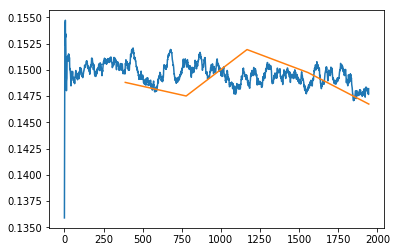

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save(model_name+'_stage-2-64-rn34')

## 128

In [27]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

/home/fabsta/projects/deeplearning/fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


torch.Size([3, 128, 128])

In [28]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


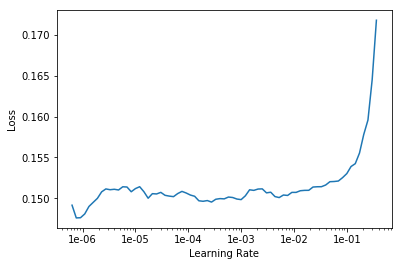

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
lr=1e-2/2

In [31]:
learn.fit_one_cycle(5, slice(lr))

Total time: 05:18
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.146812    0.142048    0.951521         0.078967  0.456339  (01:03)
2      0.146314    0.142743    0.951676         0.086740  0.471973  (01:03)
3      0.142830    0.138697    0.952561         0.098252  0.479104  (01:03)
4      0.139702    0.136930    0.953211         0.107463  0.488154  (01:03)
5      0.139691    0.140847    0.953325         0.105372  0.490425  (01:03)



In [32]:
learn.save(model_name+'_stage-1-128-rn34')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 05:25
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.140818    0.137059    0.952929         0.099941  0.483895  (01:05)
2      0.139360    0.155150    0.952216         0.107448  0.484219  (01:05)
3      0.137982    0.139058    0.954245         0.128305  0.504761  (01:05)
4      0.134083    0.132896    0.954797         0.132686  0.519310  (01:04)
5      0.132038    0.142681    0.954613         0.141453  0.519895  (01:05)



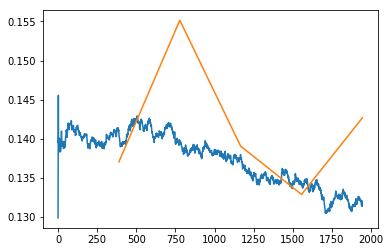

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(model_name+'_stage-2-128-rn34')

## 256

In [ ]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


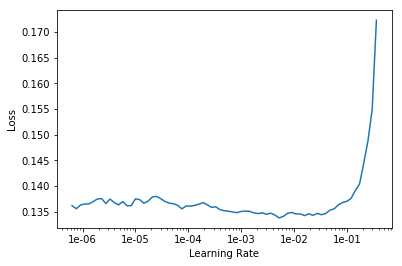

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 09:05
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.128615    0.125622    0.957159         0.177845  0.557439  (01:50)
2      0.124958    0.126659    0.957418         0.183453  0.569143  (01:48)
3      0.122077    0.147919    0.958188         0.199267  0.587589  (01:48)
4      0.119097    0.123823    0.959435         0.213885  0.589508  (01:49)
5      0.117250    0.116125    0.959481         0.220467  0.591271  (01:48)



In [ ]:
learn.save(model_name+'_stage-1-256-rn34')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 11:52
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.119839    0.152889    0.956986         0.210665  0.579680  (02:22)
2      0.119619    0.122390    0.959061         0.219250  0.589337  (02:22)
3      0.114546    0.111964    0.960710         0.241389  0.606062  (02:22)
4      0.110519    0.106938    0.961993         0.261542  0.622926  (02:22)
5      0.107166    0.109793    0.962475         0.268487  0.626483  (02:22)



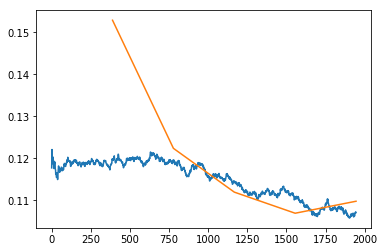

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(model_name+'_stage-2-256-rn34')

In [ ]:
#learn.load(model_name+'_'stage-2-256-rn34')

## 512

In [ ]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=512)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [ ]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


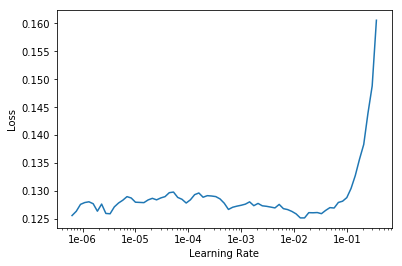

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 33:20
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.108796    0.131803    0.959056         0.203840  0.596909  (06:41)
2      0.109844    0.136003    0.960239         0.246988  0.607514  (06:39)
3      0.102890    0.106406    0.962073         0.245880  0.630939  (06:39)
4      0.101800    0.104329    0.963883         0.264073  0.655938  (06:39)
5      0.099213    0.101735    0.963786         0.269761  0.653439  (06:40)



In [ ]:
learn.save(model_name+'_stage-1-512-rn34')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,f1,fbeta
1,0.102431,0.122090,0.960171,0.248581,0.626421


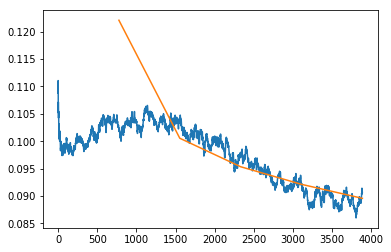

In [58]:
learn.recorder.plot_losses()

In [59]:
learn.save(model_name+'_stage-2-512-rn34')

### Predict 

In [15]:
learn.load(model_name+'_stage-1-512-rn34')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f9de2dcae10>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [60]:
# add test databunch
learn.data = (src.add_test_folder('test_combined')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [62]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x]
test_ids = get_image_names(learn.data)

In [ ]:
def get_tags(predictions, data):
    return [" ".join(data.test_ds.ds.classes[i] for i,el in enumerate(predictions[j] > 0.2) if el==1)
            for j in range(len(predictions))]

In [ ]:
os.makedirs('data/submits', exist_ok=True)

## Run standard predictions

In [61]:
preds, _ = learn.get_preds(DatasetType.Test)

/home/fabsta/.conda/envs/fastai_dl_course/lib/python3.7/site-packages/torch/nn/functional.py:1129: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [63]:
tags = get_tags(preds, learn.data)

In [64]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})
submit_df.sort_values(by='Id', inplace=True)
submit_df.to_csv('data/submits/fastai_starter.csv', header=True, index=False)
# gives 0.212 on LB

## Run tta predictions

In [66]:
preds_t = learn.TTA(scale=1.0, ds_type=DatasetType.Test, with_loss=False)[0]

Total time: 04:45



In [67]:
tags = get_tags(preds_t, learn.data)

In [68]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})
submit_df.sort_values(by='Id', inplace=True)
submit_df.to_csv('data/submits/fastai_starter_tta.csv', header=True, index=False)
# gives 0.213 on LB

## run with adjusted thresholds

In [69]:
ths=array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

In [82]:
#preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
# threshold = 0.5
threshold = ths
print(preds.shape)
classes = np.array(learn.data.test_ds.ds.classes)
tags = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds_t.numpy()])

torch.Size([11702, 28])


In [83]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})
submit_df.sort_values(by='Id', inplace=True)
submit_df.to_csv('data/submits/fastai_starter_tta_thresholds.csv', header=True, index=False)

## run with adjusted thresholds and sigmoid

In [ ]:
4 + 3

In [ ]:
# Other predictions

In [16]:
# add test databunch
learn.data = (src.add_test_folder('test_combined')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

/home/fabsta/projects/deeplearning/fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


## Get all image ids

In [45]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x]

test_ids = get_image_names(learn.data)

In [47]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(sample)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(test_ids,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [24]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))
preds_t = learn.TTA(scale=1.0, ds_type=DatasetType.Test, with_loss=False)[0]

#preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1)

Total time: 04:42



In [48]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  1.0


KeyError: '00008af0-bad0-11e8-b2b8-ac1f6b6435d0'

In [44]:
pred_t

array([0.731059, 0.730813, 0.731059, 0.731059, 0.731059, 0.731058, 0.731059, 0.731059, 0.731047, 0.731059, 0.731059,
       0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059,
       0.731059, 0.731059, 0.731059, 0.731059, 0.731059, 0.731059], dtype=float32)

In [20]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x]

In [21]:
test_ids = get_image_names(learn.data)

In [22]:
def get_tags(predictions, data):
    return [" ".join(data.test_ds.ds.classes[i] for i,el in enumerate(predictions[j] > 0.2) if el==1)
            for j in range(len(predictions))]

In [23]:
tags = get_tags(preds, learn.data)

In [24]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})

#### Need to sort by Id, couse the order metters 

In [25]:
submit_df.sort_values(by='Id', inplace=True)

In [26]:
os.makedirs('data/submits', exist_ok=True)

In [27]:
submit_df.to_csv('data/submits/your_submission.csv', header=True, index=False)

In [28]:
from IPython.display import FileLink
FileLink('data/submits/your_submission.csv')

/home/fabsta/projects/datascience/competitions/kaggle_human_protein_segmentation/nbs/data/submits/your_submission.csv

In [ ]:
preds = learn.TTA(scale=1.0, ds_type=DatasetType.Test, with_loss=False)[0]